# Яндекс.Музыка

Сравнение Москвы и Петербурга окружено мифами. Например:
 * Москва — мегаполис, подчинённый жёсткому ритму рабочей недели;
 * Петербург — культурная столица, со своими вкусами.

На данных Яндекс.Музыки сравним поведение пользователей двух столиц.

**Цель исследования** — проверить три гипотезы:
1. Активность пользователей зависит от дня недели. Причём в Москве и Петербурге это проявляется по-разному.
2. В понедельник утром в Москве преобладают одни жанры, а в Петербурге — другие. Так же и вечером пятницы преобладают разные жанры — в зависимости от города. 
3. Москва и Петербург предпочитают разные жанры музыки. В Москве чаще слушают поп-музыку, в Петербурге — русский рэп.

**Ход исследования**

Данные о поведении пользователей получены из файла `yandex_music_project.csv`. О качестве данных ничего не известно. Поэтому перед проверкой гипотез понадобится обзор данных. 

Исследование пройдёт в три этапа:
 1. Обзор данных.
 2. Предобработка данных.
 3. Проверка гипотез.



## Обзор данных

Составим первое представление о данных Яндекс.Музыки.




In [241]:
import pandas as pd # импорт библиотеки pandas
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json
import urllib.parse
sns.set(style='whitegrid', palette = 'tab10')

In [242]:
df = pd.read_csv('/datasets/yandex_music_project.csv') # чтение файла с данными и сохранение в df

In [243]:
df.head(10) # получение первых 10 строк таблицы df

,userID,Track,artist,genre,City,time,Day
0,FFB692EC,Kamigata To Boots,The Mass Missile,rock,Saint-Petersburg,20:28:33,Wednesday
1,55204538,Delayed Because of Accident,Andreas Rönnberg,rock,Moscow,14:07:09,Friday
2,20EC38,Funiculì funiculà,Mario Lanza,pop,Saint-Petersburg,20:58:07,Wednesday
3,A3DD03C9,Dragons in the Sunset,Fire + Ice,folk,Saint-Petersburg,08:37:09,Monday
4,E2DC1FAE,Soul People,Space Echo,dance,Moscow,08:34:34,Monday
5,842029A1,Преданная,IMPERVTOR,rusrap,Saint-Petersburg,13:09:41,Friday
6,4CB90AA5,True,Roman Messer,dance,Moscow,13:00:07,Wednesday
7,F03E1C1F,Feeling This Way,Polina Griffith,dance,Moscow,20:47:49,Wednesday
8,8FA1D3BE,И вновь продолжается бой,NaN,ruspop,Moscow,09:17:40,Friday
9,E772D5C0,Pessimist,NaN,dance,Saint-Petersburg,21:20:49,Wednesday


In [244]:
df.info() # получение общей информации о данных в таблице df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65079 entries, 0 to 65078
Data columns (total 7 columns):
  userID    65079 non-null object
Track       63848 non-null object
artist      57876 non-null object
genre       63881 non-null object
  City      65079 non-null object
time        65079 non-null object
Day         65079 non-null object
dtypes: object(7)
memory usage: 3.5+ MB


Итак, в таблице семь столбцов. Тип данных во всех столбцах — `object`.

Согласно документации к данным:
* `userID` — идентификатор пользователя;
* `Track` — название трека;  
* `artist` — имя исполнителя;
* `genre` — название жанра;
* `City` — город пользователя;
* `time` — время начала прослушивания;
* `Day` — день недели.

В названиях колонок видны три нарушения стиля:
1. Строчные буквы сочетаются с прописными.
2. Встречаются пробелы.
3. Встречается слитное написание слов.



Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.


**Выводы**

В каждой строке таблицы — данные о прослушанном треке. Часть колонок описывает саму композицию: название, исполнителя и жанр. Остальные данные рассказывают о пользователе: из какого он города, когда он слушал музыку. 

Предварительно можно утверждать, что, данных достаточно для проверки гипотез. Но встречаются пропуски в данных, а в названиях колонок — расхождения с хорошим стилем.

Чтобы двигаться дальше, нужно устранить проблемы в данных.

## Предобработка данных
Исправьим стиль в заголовках столбцов, исключим пропуски. Затем проверим данные на дубликаты.

### Стиль заголовков


In [245]:
df.columns # перечень названий столбцов таблицы df

Index(['  userID', 'Track', 'artist', 'genre', '  City  ', 'time', 'Day'], dtype='object')

Приведем названия в соответствие с хорошим стилем:
Для этого переименем колонки так:
* `'  userID'` → `'user_id'`;
* `'Track'` → `'track'`;
* `'  City  '` → `'city'`;
* `'Day'` → `'day'`.

In [246]:
df = df.rename(columns={'  userID' : 'user_id',\
                        'Track' : 'track',\
                        '  City  ' : 'city',\
                        'Day' : 'day'}) # переименование столбцов

In [247]:
df.columns # проверка результатов - перечень названий столбцов

Index(['user_id', 'track', 'artist', 'genre', 'city', 'time', 'day'], dtype='object')

### Пропуски значений


In [248]:
df.isna().sum() # подсчёт пропусков

user_id       0
track      1231
artist     7203
genre      1198
city          0
time          0
day           0
dtype: int64

Не все пропущенные значения влияют на исследование. Так в `track` и `artist` пропуски не важны для вашей работы. Достаточно заменить их явными обозначениями.

Но пропуски в `genre` могут помешать сравнению музыкальных вкусов в Москве и Санкт-Петербурге. На практике было бы правильно установить причину пропусков и восстановить данные. Такой возможности нет в учебном проекте. Придётся:
* заполнить и эти пропуски явными обозначениями,
* оценить, насколько они повредят расчётам. 

Для упрощения работы с пропусками проверим наличие и устраним сначала строки с явными дубликатами

In [249]:
df.duplicated().sum() # подсчёт явных дубликатов

3826

In [250]:
df = df.drop_duplicates().reset_index(drop=True)

Так как пропуски встречаются только в трех столбцах, составим таблицу для оценки количества отсутвующих данных. 

In [251]:
nan_count = pd.DataFrame(columns=['title_exis','artist_exis','genre_exis','number']) # создаем датафрейм для подсчета
for a in [True, False]:
  for b in [True, False]:
    for c in [True, False]:
      number = df[(df.track.isna() == a) & (df.artist.isna() == b) & (df.genre.isna() == c)].shape[0] #подсчитываем количество
      nan_count = nan_count.append({'title_exis' : a, "artist_exis": b, "genre_exis": c,  "number": number},\
                                   ignore_index=True) #заполняем датафрейм
display(nan_count)

,title_exis,artist_exis,genre_exis,number
0,True,True,True,619
1,True,True,False,536
2,True,False,True,0
3,True,False,False,0
4,False,True,True,163
5,False,True,False,5454
6,False,False,True,345
7,False,False,False,54136


После манипуляций в данных имеется:
* 1. 619 строк не имеющих информации о треке
* 2. 536 строк в которых известен только жанр трека
* 3. 163 строки в которых известно только название трека, но нет информации об исполнителе и жанре
* 4. 5454 строки с неизвестным исполнителем
* 5. 345 строки в которых нет информации о жанре, но есть данные о названии трека и исполнителе
* 6. 54136 строк с полными данными

Исходя из этого, можно частично востановить информацию, необходимую в данном исследовании, о жанре аудиотрека у данных из пунктов 3 и 5 по названию трека и исполнителю. 

In [252]:
def genre_by_artist(artist): #функция для поиска жанра по артисту
    try:
        url = 'https://music.yandex.ru/handlers/music-search.jsx'
        params={'text': urllib.parse.quote(artist),
                'type' : 'artist'}
        cookies = {
        'gdpr': '0',
        'mda': '0',
        'yandex_gid': '38',
        'is_gdpr_b': 'COaIGBD2TigC',
        'is_gdpr': '0',
        'bltsr': '1',
        'yandexuid': '2450519631594838815',
        'yuidss': '2450519631594838815',
        'ymex': '1638608355.oyu.9406303111635779726#1951328489.yrts.1635968489#1951376355.yrtsi.1636016355',
        'L': 'Zgphc0sAQG5uZmJDVwB4B19KAABeWX5SLjEWIgFZHAtXODU0IBRCRT0=.1636018956.14779.348618.90f786b86fc62fc25cbab0ba94aebfe5',
        'yandex_login': 'metall_20@mail.ru',
        'my': 'YwA=',
        'Nickel': '1',
        'Radon': '1',
        'Manganese': '1',
        'i': 'ax6Axor8yRIc1KunUwZ0Ojpj3ZYFgEgarOQH/9ckrzSaKmVksHcyglb4hkmvZnAkiiacfG/aFXqsaQ3Jm73dFWCHukA=',
        'Session_id': '3:1636821816.5.0.1636018956086:5D3pvA:8.1|1508812044.-1.0.1:305410596|3:243567.885568.OBaotNoMzlfmwu5XlJslzC4XKAA',
        'sessionid2': '3:1636821816.5.0.1636018956086:5D3pvA:8.1|1508812044.-1.0.1:305410596|3:243567.885568.OBaotNoMzlfmwu5XlJslzC4XKAA',
        '_ym_uid': '1594838816713899162',
        'computer': '1',
        'LBCBNrZSu': '1',
        'kidsTabTooltipShown': '1',
        'pepsi_year': 'today',
        'safeframe-test-cookie_1636987515881_43_1': 'test',
        '_ym_isad': '2',
        'VTouhmwR': '1',
        '_ym_d': '1636999336',
        '_yasc': 'XFtYOD8USUONeDAlDfIjRaKTEkAF4WY/+Lb5iDPRxnQ8rwAXPxd2vHPvIgY=',
        'yabs-frequency': '/5/00010000003MdLnX/ohdHPci00030Go7KoImF3W000C138RAMB4H30000m4CXOgH1ROO00030GoU2OK5jXW000BX38zgIfCn34kfom4F07SvxfH5gytt0G-1HxyKNv2UVSy530099znZMNaanTi13882H5D7-EEzYm4D0sN29jnIpaat1Gy02WFeWDc9_qrR0Go1JwbovPL8vVS13G16_KW8OghjyXqFy____PprAoyHjzMB0G-06CGbPxqMqTy13O6FWZwpsQiPfmKCW0cDAzBnKAfvumKC01Hdooy4TlaTjm4CWbqyobYOQBah1Gw01Y0ySS9800030Go3x4XnmaW000C138ACrP3LaKTjom4CW/',
        'ys': 'udn.cDptZXRhbGxfMjBAbWFpbC5ydQ%3D%3D#wprid.1636999338430633-5872689049903018219-sas2-2338-sas-l7-balancer-8080-BAL-2532#c_chck.3913386717',
        'yp': '1639591340.los.1#1639591340.losc.0#1668526101.p_sw.1636990100#1651796398.szm.1:1440x900:1440x789#1951378956.udn.cDptZXRhbGxfMjBAbWFpbC5ydQ%3D%3D#1637251529.mcv.0#1637251529.mcl.1o48vqd#1637252402.mct.null',
        'device_id': 'a25cc617db69f4afee43b2b3157cd447a950d35d8',
        'active-browser-timestamp': '1636999342098',
        '_ym_visorc': 'b',
        '_gcl_au': '1.1.990358599.1636999343',
        'lastVisitedPage': '%7B%7D'}

        headers = {'user-agent' : 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36'}
        res = requests.get(url, headers=headers, params=params,  cookies=cookies)
        return str(res.json()['artists']['items'][0]['genres'][0])
    except (IndexError, KeyError):        
        return 'unknown' #если информации нет, возвращаем 'unknown'

In [253]:
def genre_by_track(track): #функция для поиска жанра по названию трека
    try:
        url = 'https://music.yandex.ru/handlers/music-search.jsx'
        params={'text': urllib.parse.quote(track),
                'type' : 'tracks'}
        cookies = {
        'gdpr': '0',
        'mda': '0',
        'yandex_gid': '38',
        'is_gdpr_b': 'COaIGBD2TigC',
        'is_gdpr': '0',
        'bltsr': '1',
        'yandexuid': '2450519631594838815',
        'yuidss': '2450519631594838815',
        'ymex': '1638608355.oyu.9406303111635779726#1951328489.yrts.1635968489#1951376355.yrtsi.1636016355',
        'L': 'Zgphc0sAQG5uZmJDVwB4B19KAABeWX5SLjEWIgFZHAtXODU0IBRCRT0=.1636018956.14779.348618.90f786b86fc62fc25cbab0ba94aebfe5',
        'yandex_login': 'metall_20@mail.ru',
        'my': 'YwA=',
        'Nickel': '1',
        'Radon': '1',
        'Manganese': '1',
        'i': 'ax6Axor8yRIc1KunUwZ0Ojpj3ZYFgEgarOQH/9ckrzSaKmVksHcyglb4hkmvZnAkiiacfG/aFXqsaQ3Jm73dFWCHukA=',
        'Session_id': '3:1636821816.5.0.1636018956086:5D3pvA:8.1|1508812044.-1.0.1:305410596|3:243567.885568.OBaotNoMzlfmwu5XlJslzC4XKAA',
        'sessionid2': '3:1636821816.5.0.1636018956086:5D3pvA:8.1|1508812044.-1.0.1:305410596|3:243567.885568.OBaotNoMzlfmwu5XlJslzC4XKAA',
        '_ym_uid': '1594838816713899162',
        'computer': '1',
        'LBCBNrZSu': '1',
        'kidsTabTooltipShown': '1',
        'pepsi_year': 'today',
        'safeframe-test-cookie_1636987515881_43_1': 'test',
        '_ym_isad': '2',
        'VTouhmwR': '1',
        '_ym_d': '1636999336',
        '_yasc': 'XFtYOD8USUONeDAlDfIjRaKTEkAF4WY/+Lb5iDPRxnQ8rwAXPxd2vHPvIgY=',
        'yabs-frequency': '/5/00010000003MdLnX/ohdHPci00030Go7KoImF3W000C138RAMB4H30000m4CXOgH1ROO00030GoU2OK5jXW000BX38zgIfCn34kfom4F07SvxfH5gytt0G-1HxyKNv2UVSy530099znZMNaanTi13882H5D7-EEzYm4D0sN29jnIpaat1Gy02WFeWDc9_qrR0Go1JwbovPL8vVS13G16_KW8OghjyXqFy____PprAoyHjzMB0G-06CGbPxqMqTy13O6FWZwpsQiPfmKCW0cDAzBnKAfvumKC01Hdooy4TlaTjm4CWbqyobYOQBah1Gw01Y0ySS9800030Go3x4XnmaW000C138ACrP3LaKTjom4CW/',
        'ys': 'udn.cDptZXRhbGxfMjBAbWFpbC5ydQ%3D%3D#wprid.1636999338430633-5872689049903018219-sas2-2338-sas-l7-balancer-8080-BAL-2532#c_chck.3913386717',
        'yp': '1639591340.los.1#1639591340.losc.0#1668526101.p_sw.1636990100#1651796398.szm.1:1440x900:1440x789#1951378956.udn.cDptZXRhbGxfMjBAbWFpbC5ydQ%3D%3D#1637251529.mcv.0#1637251529.mcl.1o48vqd#1637252402.mct.null',
        'device_id': 'a25cc617db69f4afee43b2b3157cd447a950d35d8',
        'active-browser-timestamp': '1636999342098',
        '_ym_visorc': 'b',
        '_gcl_au': '1.1.990358599.1636999343',
        'lastVisitedPage': '%7B%7D'}

        headers = {'user-agent' : 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36'}
        res = requests.get(url, headers=headers, params=params,  cookies=cookies)
        return str(res.json()['tracks']['items'][0]['albums'][0]['genre'])
    except (IndexError, KeyError):        
        return 'unknown' #если информации нет, возвращаем 'unknown'

In [254]:
#заполняем функцией строки без жанра, но с исполнителем
df.loc[((df.artist.isna() == False) & (df.genre.isna())),'genre'] =\
df.loc[((df.artist.isna() == False) & (df.genre.isna())), 'artist'].apply(genre_by_artist) 
# подождите, пожалуйста, ~2 минуты

In [255]:
#заполняем функцией строки без жанра, но с названием трека
df.loc[((df.track.isna() == False) & (df.genre.isna())),'genre'] =\
df.loc[((df.track.isna() == False) & (df.genre.isna())), 'track'].apply(genre_by_track) 
# пожалуйста еще 2 минуты

In [256]:
df = df.fillna('unknown') #все остальные пропущенные данные заменяем на 'unknown'

Убедимся, что в таблице не осталось пропусков, посчитав пропущенные значения.

In [257]:
df.isna().sum()# подсчёт пропусков

user_id    0
track      0
artist     0
genre      0
city       0
time       0
day        0
dtype: int64

### Дубликаты
Для упрощения заполнения пропусков, явные дубликаты удалены в прошлом пункте, теперь избавимся от неявных дубликатов в колонке `genre`. Hазвание одного и того же жанра может быть записано немного по-разному. Такие ошибки тоже повлияют на результат исследования.

Выведем на экран список уникальных названий жанров, отсортированный в алфавитном порядке.

In [258]:
df.genre.sort_values().unique() # Просмотр уникальных названий жанров

array(['acid', 'acoustic', 'action', 'adult', 'africa', 'afrikaans',
       'alternative', 'alternativepunk', 'ambient', 'amerfolk',
       'americana', 'animated', 'anime', 'arabesk', 'arabic', 'arena',
       'argentinetango', 'armenian', 'art', 'audiobook', 'author',
       'avantgarde', 'axé', 'baile', 'balkan', 'beats', 'bigroom',
       'black', 'bluegrass', 'blues', 'bollywood', 'bossa', 'brazilian',
       'breakbeat', 'breakbeatgenre', 'breaks', 'broadway', 'cantautori',
       'cantopop', 'canzone', 'caribbean', 'caucasian', 'celtic',
       'chamber', 'chanson', 'children', 'chill', 'chinese', 'choral',
       'christian', 'christmas', 'classical', 'classicalmasterpieces',
       'classicmetal', 'club', 'colombian', 'comedy', 'conjazz',
       'contemporary', 'country', 'cuban', 'dance', 'dancehall',
       'dancepop', 'dark', 'death', 'deep', 'deutschrock', 'deutschspr',
       'dirty', 'disco', 'dnb', 'documentary', 'downbeat', 'downtempo',
       'drum', 'dub', 'dubstep',

В списоке присутствуют неявные дубликаты жанров. Это названия с ошибками или альтернативные названия того же жанра.
Чтобы очистить от них таблицу, напишем функцию `replace_wrong_genres()` с двумя параметрами: 
* `wrong_genres` — список дубликатов,
* `correct_genre` — строка с правильным значением.

In [259]:
def replace_wrong_genres(df, wrong_genres, correct_genre): # Функция для замены неявных дубликатов
    for wrong in wrong_genres:
        df.genre = df.genre.replace(wrong, correct_genre)

Составим словарь `change_genres` в котором ключем является коректное название, а значениями списоки ошибочных вариантов присутвубщие в наших данных.
Вызовем `replace_wrong_genres()` для устранения неявных дубликатов.

In [260]:
change_genres = {'adult' : [ 'contemporary'],
                 'african' : ['africa', 'afrikaans'],
                 'american' : ['americana'],
                 'anime' : ['fairytail'],
                 'arabesk' : ['arabic'],
                 'breakbeat' : ['beats', 'breaks'],
                 'downbeat' : ['downtempo', "slow"],
                 'dnb' : ['drum'],
                 'dubstep' : ['dub'],
                 'french' : ['frankreich', 'französisch'],
                 'german' : ['deutschspr', 'tanzorchester'],
                 'christian' : ['gospel'],
                 'hiphop' : ['hip', 'hop', 'hip-hop'],
                 'indie' : ['independent'],
                 'jpop' : ['kayokyoku'],
                 'kpop' : ['k-pop'],
                 'latin' : ['latino'],
                 'neoclassical' : ['neoklassik'],
                 'new' : ['neue'],
                 'brazilian' : ['mpb'],
                 'dancepop' : ['popdance', 'popeurodance'],
                 'electropop' : ['popelectronic'],
                 'postrock' : ['post'],
                 'alternative' : ['rockalternative'],
                 'ruspop' : ['poprussian'],
                 'rockindie' : ['shoegazing'],
                 'soul' : ['soulful'],
                 'soundtrack' : ['sound'],
                 'self' : ['sängerportrait'],
                 'turkishrock' : ['taraftar'],
                 'techno' : ['tech'],
                 'triphop' : [ 'trip'],
                 'turkish' : ['türk', 'türkçe'],
                 'pop' : ['ïîï'],
                 'electronic' : ['электроника', 'electronics']}
for correct_genre, wrong_genres in change_genres.items():
    replace_wrong_genres(df, wrong_genres, correct_genre)
# Устранение неявных дубликатов

Проверим, взглянув на отсортированный список уникальных значений столбца `genre`:

In [261]:
df.genre.sort_values().unique() # Проверка на неявные дубликаты

array(['acid', 'acoustic', 'action', 'adult', 'african', 'alternative',
       'alternativepunk', 'ambient', 'amerfolk', 'american', 'animated',
       'anime', 'arabesk', 'arena', 'argentinetango', 'armenian', 'art',
       'audiobook', 'author', 'avantgarde', 'axé', 'baile', 'balkan',
       'bigroom', 'black', 'bluegrass', 'blues', 'bollywood', 'bossa',
       'brazilian', 'breakbeat', 'breakbeatgenre', 'broadway',
       'cantautori', 'cantopop', 'canzone', 'caribbean', 'caucasian',
       'celtic', 'chamber', 'chanson', 'children', 'chill', 'chinese',
       'choral', 'christian', 'christmas', 'classical',
       'classicalmasterpieces', 'classicmetal', 'club', 'colombian',
       'comedy', 'conjazz', 'country', 'cuban', 'dance', 'dancehall',
       'dancepop', 'dark', 'death', 'deep', 'deutschrock', 'dirty',
       'disco', 'dnb', 'documentary', 'downbeat', 'dubstep', 'eastern',
       'easy', 'electronic', 'electropop', 'emo', 'entehno', 'epicmetal',
       'estrada', 'ethnic', 

В `genre` имеется много разновидностей музыкальных жанров относящихся к одному и тому же направлению, но представленные разными названиями ответвлений. Это размывает истинную картину и не позволяет оценить реальную популярность жанра. Поэтому создадим классификатор поджанров по направлениям.

In [262]:
genre_class = {'pop' : ["disco","kpop", "dancepop", "handsup",
                        "ruspop", "teen", "traditional"], 
              'allrock' : ["rusrock", "rnr", "progrock", "postrock",
                           "newwave", "folkrock", "stonerrock",
                           "hardrock", "rock","adult", "arena", "art","chamber",
                           "hard'n'heavy", "indipop", "ram", "rockabilly",
                           "rockother", "soft", "southern"], 
              'indie' : ["local-indie"],
              'metal' : ["progmetal", "epicmetal", "folkmetal", "gothic",
                         "industrial", "sludgemetal","postmetal", "extrememetal",
                         "numetal", "metalcore", "classicmetal",
                         "thrash", "death", "black", "doommetal", 'emo', "power"],
              'alternative' : ["posthardcore", "hardcore",
                               "alternativepunk", "grunge", "rockindie"], 
              'electronic' : ["techno", "house", "trance", "breakbeatgenre", 
                            "dnb", "dubstep", "ambient", "experimental",
                             "dance", "acid", "bigroom", "club", "dark",
                              "deep", "downbeat", "electropop", "folktronica",
                              "future", "garage", "glitch", "grime", "hardstyle",
                              "hardtechno", "idm", "jungle", "leftfield",
                              "minimal", "nu", "progressive", "rave", "synthpop",
                              "synthrock", "tribal", "tropical"], 
               'hiphop' : ["rusrap","breakbeat", "dirty", "gangsta",
                           "rap", "triphop", "urban", "foreignrap"],
               'rnb' : ["soul","funk", 'baile', "rhythm"], 
               'jazz' : ["trad-jass","modern-jazz", "conjazz", "nujazz",
                         "smooth", "swing", "tradjazz"], 
               'blues' : [],
               'reggae' : ["reggaeton","dub", "dancehall", "ragga", "vi"],
               'ska' : ["skarock"], #
               'punk' : ["gypsy"],
               'world' : ["russian", "tatar", "celtic", "balkan",
                          "european", "jewish", "eastern", "african",
                          "latin-american", "american", "romances",
                          "argentinetango", "armenian", "georgian",
                          "azerbaijani", "caucasian", "turkishclassical",
                          "arabesk", "turkishfolk", "axé", "bossa", "brazilian",
                          "cantautori", 'cantopop', "canzone", "caribbean",
                          "chinese", 'colombian', 'cuban', "deutschrock",
                          "german", "entehno", 'ethnic', 'eurofolk',
                          'european', "fado", "flamenco", "folk", "forró",
                          "french", "ghazal", "indian","international",
                          "irish", "japanese", "jewish", "jpop", "karadeniz",
                          "korean", "laiko", "malaysian", "mandopop",
                          "mediterranean", "mexican", "mpb",
                          "muslim", "oceania", "punjabi", "quebecois",
                          "rancheras", "regional", "speech",
                          "turkish", "uzbek", "western","turkishpop",
                          "uzbekpop","japanesepop","israelipop","azerbaijanpop",
                          "ukrrock", "turkishrock", "israelirock",
                          "turkishalternative","turkishrap", "israelirap",
                          "amerfolk", "latinfolk"], 
               'estrada' : ["rusestrada", "schlager", "variété"],
               'shanson' : [],
               'country' : ['bluegrass'],
               'soundtrack' : ["film", "tv-series", "animated",
                               "videogame", "musical",
                               "bollywood", "anime",  "action", "broadway",
                               "documentary", "horror",
                               "miscellaneous", "scenic"], 
               'easy' : ["lounge", "meditative", "acoustic", 'chill',
                         "gitarre", "instrumental", "lounge",
                         "loungeelectronic", "melodic", "newage", "relax"], 
               'singersongwriter' : ["rusbards", "foreignbard", 'author',
                                     "self", "singer", "sängerportrait"], 
               'podcast' : ["arts", "business", "comedy", "education",
                            "health", "music", "hobbies", "technology",
                            "government", "history", "familypodcasts",
                            "news", "religion", "science", "society",
                            "recreation", "filmpodcasts",
                            "narrative", "artwork"],
               
               'classicalmusic' : ["opera", "modern-classical", "orchestral"
                                   "classical", "classicalmasterpieces",
                                   'avantgarde', "choral", "neoclassical",
                                   "piano", "romance", "vocal"], 
               'fiction' : ["romancenovel", "historicalfiction",
                            "sciencefiction", "fantasyliterature",
                            "actionandadventure", "crimeandmystery",
                            "dramaliterature", "sertanejo"],
               'audiobook' : [], #
               'other' : ["sport", "holiday", 'christian', 'christmas',
                          "fitness", "folklore", "historisch", "hymn",
                          "inspirational", "jam", "karaoke",
                          "local", "lovers", "marschmusik", "middle", "modern",
                          "mood", "native", "new", "old", "psychedelic",
                          "religious", "retro", "roots", "salsa", "samba",
                          "showtunes", "specialty", "spiritual", "surf",
                           "tango", "top", "unknown", "worldbeat", "forchildren","rusfolk"]} 

def replaiser(sub, genre_class): #функция для определения жанра по поджанру
    for genre, subgenre in genre_class.items():
      if sub in subgenre:
        return genre
    return sub

А имеющиеся данные о `genre` переименуем в `subgenre`

In [263]:
df = df.rename(columns={'genre' : 'subgenre'})

Заполняем новой информацией о жанре используя созданный классификатор 

In [264]:
df.insert(3, 'genre', df.apply(lambda x: replaiser(x.subgenre, genre_class), axis=1)) #добавление столбца с актуальным жанром
# Есть вариант лучше/лаконичнее?

Посмотрим на данные после предобработки.

In [265]:
display(df)

,user_id,track,artist,genre,subgenre,city,time,day
0,FFB692EC,Kamigata To Boots,The Mass Missile,allrock,rock,Saint-Petersburg,20:28:33,Wednesday
1,55204538,Delayed Because of Accident,Andreas Rönnberg,allrock,rock,Moscow,14:07:09,Friday
2,20EC38,Funiculì funiculà,Mario Lanza,pop,pop,Saint-Petersburg,20:58:07,Wednesday
3,A3DD03C9,Dragons in the Sunset,Fire + Ice,world,folk,Saint-Petersburg,08:37:09,Monday
4,E2DC1FAE,Soul People,Space Echo,electronic,dance,Moscow,08:34:34,Monday
...,...,...,...,...,...,...,...,...
61248,729CBB09,My Name,McLean,rnb,rnb,Moscow,13:32:28,Wednesday
61249,D08D4A55,Maybe One Day (feat. Black Spade),Blu & Exile,hiphop,hiphop,Saint-Petersburg,10:00:00,Monday
61250,C5E3A0D5,Jalopiina,unknown,metal,industrial,Moscow,20:09:26,Friday
61251,321D0506,Freight Train,Chas McDevitt,allrock,rock,Moscow,21:43:59,Friday


**Выводы**

Предобработка обнаружила 4 проблемы в данных:

- нарушения в стиле заголовков,
- пропущенные значения,
- дубликаты — явные и неявные.
- неявственная информация о жанре

По мере возможности проблемы исправлены что позволит получить более точные результаты исследования. 

Теперь можно перейти к проверке гипотез. 

## Проверка гипотез

### Сравнение поведения пользователей двух столиц

Первая гипотеза утверждает, что пользователи по-разному слушают музыку в Москве и Санкт-Петербурге. Проверим это предположение.

day,Monday,Wednesday,Friday
city,,,
Moscow,15740,11056,15945
Saint-Petersburg,5614,7003,5895


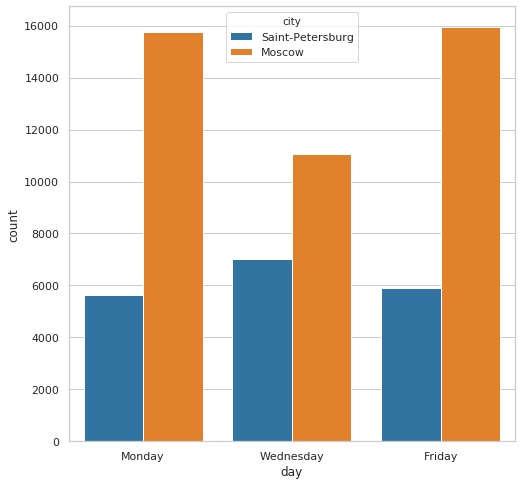

In [266]:
city_track_count = df.pivot_table(values='user_id', columns='day', index='city', aggfunc='count')\
                     .reindex(columns=['Monday','Wednesday','Friday']) # Подсчёт прослушиваний в каждом городе по дням недели
display(city_track_count)
plt.figure(figsize=(8, 8))
sns.countplot(data=df, x='day', hue='city', order=['Monday','Wednesday','Friday']) 

В Москве прослушиваний больше, чем в Петербурге. Из этого не следует, что московские пользователи чаще слушают музыку. Просто самих пользователей в Москве больше.

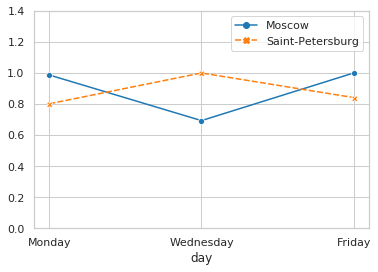

In [267]:
norm_city_count = city_track_count.T / city_track_count.T.max().T # оцениваем относительную активность
plt.ylim(0, 1.4)
sns.lineplot(data=norm_city_count, sort=False, markers=True)

**Выводы**

Данные показывают разницу поведения пользователей:

- В Москве пик прослушиваний приходится на понедельник и пятницу, а в среду заметен спад.
- В Петербурге, наоборот, больше слушают музыку по средам. Активность в понедельник и пятницу здесь почти в равной мере уступает среде.

Значит, данные говорят в пользу первой гипотезы.

### Музыка в начале и в конце недели

Согласно второй гипотезе, утром в понедельник в Москве преобладают одни жанры, а в Петербурге — другие. Так же и вечером пятницы преобладают разные жанры — в зависимости от города.

Для оценки почасовой активности слушателей, добавим дополнительный столбец `h_time` показывающий в какой час был прослушан рассматриваемый трек.

In [268]:
df.insert(7, 'h_time', df.time.astype(str).str[:2].astype(int)+1) # добавление столбца с часом прослушивания

Оценим активность пользователей на основе часа прослушивания

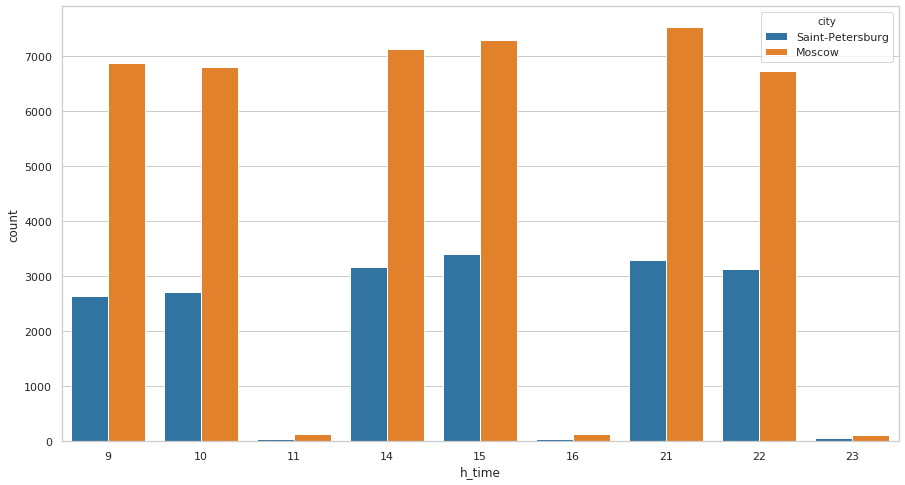

In [269]:
plt.figure(figsize=(15, 8))
sns.countplot(data=df, x='h_time', hue='city')

Оказывается в данных также практически отсутвствует информация о прослушанных треках в периоды:
* c 10 до 11
* с 15 до 16
* с 22 до 23

Удалим эти сведения полность, чтобы они не искажали дальнейшие расчеты.
И взглянем как меняется популярность 10 самых прослушиваемых жанров каждого из городов в зависимости от времени прослушивания и дня недели.

Найдем 10 самых прослушиваемых жанров каждого из городов.

In [270]:
top10_genres_m = list(df.query("city == 'Moscow'").genre.value_counts().head(10).index) # топ 10 жанров Москвы
top10_genres_sp = list(df.query("city == 'Saint-Petersburg'").genre.value_counts().head(10).index) # топ 10 жанров Питера
display(set(top10_genres_m) == set(top10_genres_sp)) # у обоих городов топ 10 совпали
top10_genres = top10_genres_m 
display(top10_genres)

True

['electronic',
 'pop',
 'allrock',
 'hiphop',
 'world',
 'other',
 'classical',
 'alternative',
 'soundtrack',
 'metal']

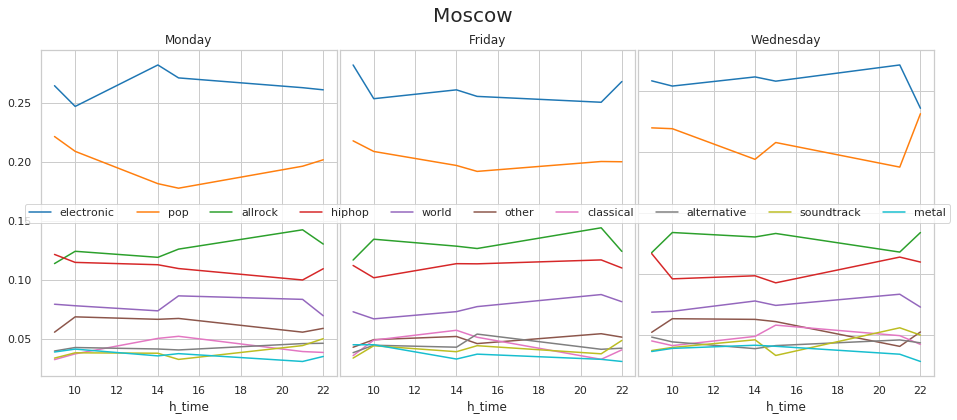

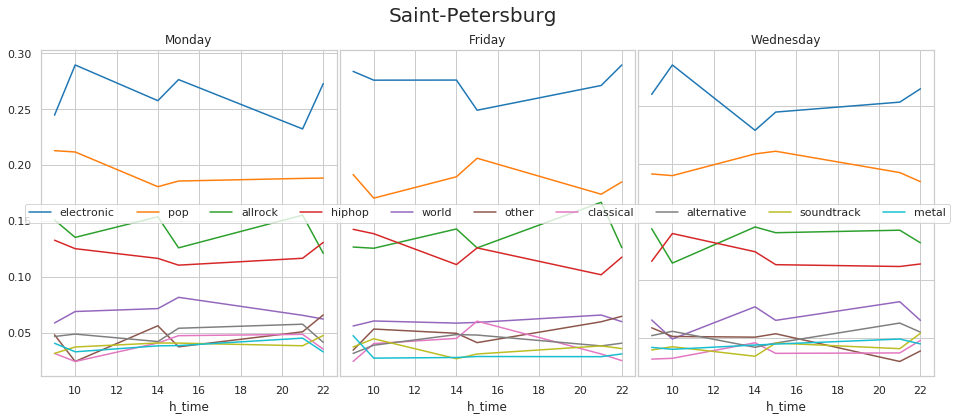

In [271]:
for city in ['Moscow', 'Saint-Petersburg']: # изобразим на графиках доли топ 10 жанров в прослушаных за каждый час треках
    
    plt.figure(figsize=(16, 6))        
    plt.suptitle(city, fontsize = 20)
    plt.subplots_adjust(wspace=0.01)
    
    for day, place, legend_v in zip(['Monday','Wednesday','Friday'],[1,3,2], [False,False,'full']):
        
        t10 = df.query(("city == @city & genre in @top10_genres & day == @day"))
        t10 = t10.pivot_table(values='user_id', columns='genre', index='h_time', aggfunc='count')\
                    .reindex(columns=top10_genres)
        t10 = t10.query('electronic > electronic.mean()/10')
        norm_t10 = t10.T/t10.T.sum()
        plt.subplot(1,3,place)
        sns.lineplot(data=norm_t10.T , dashes=False, sort=False, legend=legend_v).set_title(day)
        if place == 2:
            plt.yticks([])
            plt.legend(loc='center', ncol = 10)

Действительно доля жанра в прослушанных за час треках колеблется, но в довольно узких пределах

Посмотрим насколько различна популярность 10 самых востребованных жанров в Москве и Санкт-Петербурге в зависимости от дня недели или времени суток.

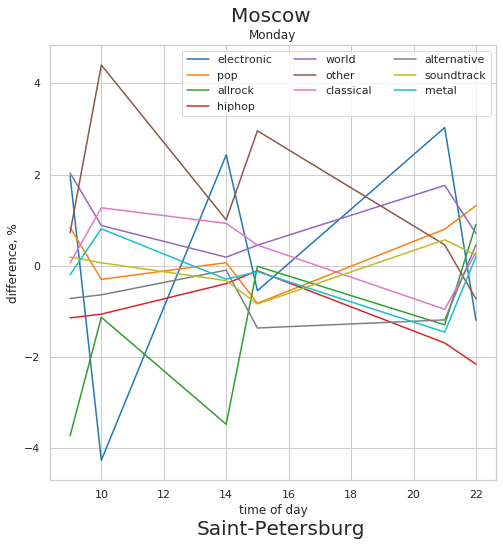

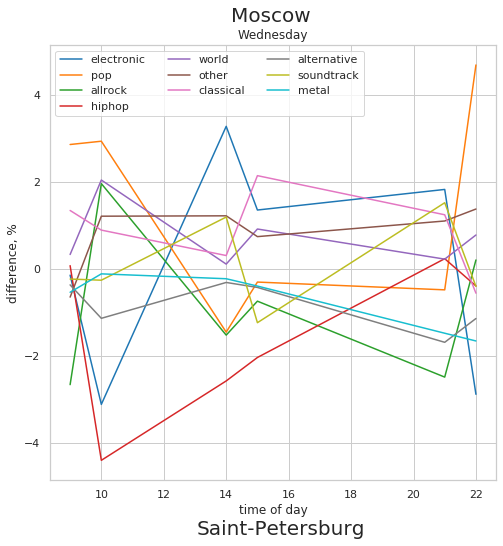

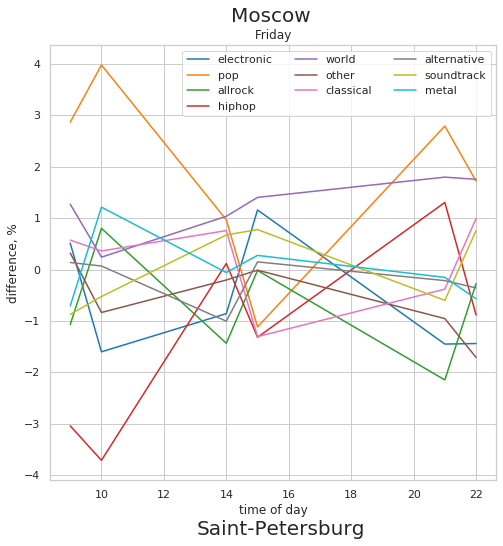

In [272]:
for day,place in zip(['Monday','Wednesday','Friday'],[1,2,3]):
    t10_genre_mos = df.query(("city == 'Moscow' & genre in @top10_genres & day == @day"))
    t10_genre_sp = df.query(("city == 'Saint-Petersburg' & genre in @top10_genres & day == @day"))
    t10m = t10_genre_mos.pivot_table(values='user_id', columns='genre', index='h_time', aggfunc='count')\
                    .reindex(columns=top10_genres).fillna(0)
    t10sp = t10_genre_sp.pivot_table(values='user_id', columns='genre', index='h_time', aggfunc='count')\
                    .reindex(columns=top10_genres).fillna(0)
    
    t10m = t10m.query('electronic > electronic.mean()/10')
    t10sp = t10sp.query('electronic > electronic.mean()/10')

    norm_t10_mos = t10m.T/t10m.T.sum()
    norm_t10_sp = t10sp.T/t10sp.T.sum()


    plt.figure(figsize=(8, 8))
    sns.lineplot(data=norm_t10_mos.T*100-norm_t10_sp.T*100 , dashes=False, sort=False).set_title(day)
    plt.legend(ncol = 3)
    plt.figtext(0.44, 0.92, "Moscow",  fontsize = 20)
    plt.figtext(0.38, 0.03, "Saint-Petersburg",  fontsize = 20)
    plt.ylabel("difference, %")
    plt.xlabel("time of day")

**Выводы**

1. В Москве и Петербурге идентичны топ-10 жанров.

2. Доля этих жанров в прослушиваемой музыке может колебаться от дня ко дню и в зависимости от времени суток, но не значительно. 

2. В Москве и Петербурге успешность топ-10 жанров совпадает.


Таким образом, вторая гипотеза подтвердилась лишь частично:
* Пользователи слушают похожую музыку в начале недели и в конце.
* Разница между Москвой и Петербургом не слишком выражена. 


In [273]:
# df.insert(7, 'h_time', df.time.astype(str).str[:2].astype(int)+1) # не удалять
# #day_activ = df.groupby(['h_time','genre','city'])

In [274]:
# #df.h_time.value_counts().sort_index()
# day_activ = df.groupby(['h_time','genre','city']).user_id.count()
# day_activ

In [275]:
# plt.figure(figsize=(16, 8))
# sns.countplot(data=df, x='h_time', hue='city')
# #sns.countplot(data=day_activ, x='h_time', hue='city', stacked=True)
# #day_activ

In [276]:
# top10_genres_m = list(df.query("city == 'Moscow'").genre.value_counts().head(10).index)
# top10_genres_sp = list(df.query("city == 'Saint-Petersburg'").genre.value_counts().head(10).index)
# display(set(top10_genres_m) == set(top10_genres_sp))
# top10_genres = top10_genres_m
# display(top10_genres)



In [277]:
# #def g_popularity (df, list_genres, days=['Monday','Wednesday','Friday'], cities=['Moscow', 'Saint-Petersburg']):
# for city in ['Moscow', 'Saint-Petersburg']:
    
#     plt.figure(figsize=(16, 6))        
#     plt.suptitle(city, fontsize = 20)
#     plt.subplots_adjust(wspace=0.01)
    
#     for day, place, legend_v in zip(['Monday','Wednesday','Friday'],[1,3,2], [False,False,'full']):
        
#         t10 = df.query(("city == @city & genre in @top10_genres & day == @day"))
#         t10 = t10.pivot_table(values='user_id', columns='genre', index='h_time', aggfunc='count')\
#                     .reindex(columns=top10_genres)
#         t10 = t10.query('electronic > electronic.mean()/10')
#         norm_t10 = t10.T/t10.T.sum()
#         #plt.figure(figsize=(16, 6))        
#         #plt.subplots_adjust(wspace=0.01)
#         plt.subplot(1,3,place)
#         sns.lineplot(data=norm_t10.T , dashes=False, sort=False, legend=legend_v).set_title(day)
#         if place == 2:
#             plt.yticks([])
#             plt.legend(loc='center', ncol = 10)
# #             plt.subplot(1,3,3)
# #             sns.lineplot(data=norm_t10.T , dashes=False, sort=False, legend=False).set_title(day)
# #             plt.subplot(1,3,2)
# #             sns.lineplot(data=norm_t10.T , dashes=False, sort=False, legend=True).set_title(day)
# #             plt.yticks([])
# #             plt.legend(loc='center', ncol = 10)
#             #return t10
    
# #g_popularity(df,top10_genres_m)    

In [278]:
# for day,place in zip(['Monday','Wednesday','Friday'],[1,2,3]):
#     t10_genre_mos = df.query(("city == 'Moscow' & genre in @top10_genres & day == @day"))
#     t10_genre_sp = df.query(("city == 'Saint-Petersburg' & genre in @top10_genres & day == @day"))
#     t10m = t10_genre_mos.pivot_table(values='user_id', columns='genre', index='h_time', aggfunc='count')\
#                     .reindex(columns=top10_genres).fillna(0)
#     t10sp = t10_genre_sp.pivot_table(values='user_id', columns='genre', index='h_time', aggfunc='count')\
#                     .reindex(columns=top10_genres).fillna(0)
    
#     t10m = t10m.query('electronic > electronic.mean()/10')
#     t10sp = t10sp.query('electronic > electronic.mean()/10')
#     #display(t10m)
#     #display(t10sp)

#     norm_t10_mos = t10m.T/t10m.T.sum()
#     norm_t10_sp = t10sp.T/t10sp.T.sum()
#     #display(norm_t10_mos)
#     #display(norm_t10_sp)

#     plt.figure(figsize=(8, 8))
#     sns.lineplot(data=norm_t10_mos.T*100-norm_t10_sp.T*100 , dashes=False, sort=False).set_title(day)
#     plt.legend(ncol = 3)
#     plt.figtext(0.44, 0.92, "Moscow",  fontsize = 20)
#     plt.figtext(0.38, 0.03, "Saint-Petersburg",  fontsize = 20)
#     plt.ylabel("difference, %")
#     plt.xlabel("time of day")

**Выводы**

Если сравнить топ-10 жанров в понедельник утром, можно сделать такие выводы:

1. В Москве и Петербурге слушают похожую музыку. Единственное отличие — в московский рейтинг вошёл жанр “world”, а в петербургский — джаз и классика.

2. В Москве пропущенных значений оказалось так много, что значение `'unknown'` заняло десятое место среди самых популярных жанров. Значит, пропущенные значения занимают существенную долю в данных и угрожают достоверности исследования.

Вечер пятницы не меняет эту картину. Некоторые жанры поднимаются немного выше, другие спускаются, но в целом топ-10 остаётся тем же самым.

Таким образом, вторая гипотеза подтвердилась лишь частично:
* Пользователи слушают похожую музыку в начале недели и в конце.
* Разница между Москвой и Петербургом не слишком выражена. В Москве чаще слушают русскую популярную музыку, в Петербурге — джаз.

Однако пропуски в данных ставят под сомнение этот результат. В Москве их так много, что рейтинг топ-10 мог бы выглядеть иначе, если бы не утерянные  данные о жанрах.

### Жанровые предпочтения в Москве и Петербурге

Гипотеза: Петербург — столица рэпа, музыку этого жанра там слушают чаще, чем в Москве.  А Москва — город контрастов, в котором, тем не менее, преобладает поп-музыка.

Частично воспользовавшись уже готовыми данными из прошлого пункта взглянем на сколько различается востребованность топ-10 жанров в Москве и Петербурге  

Text(0, 0.5, 'difference, %')

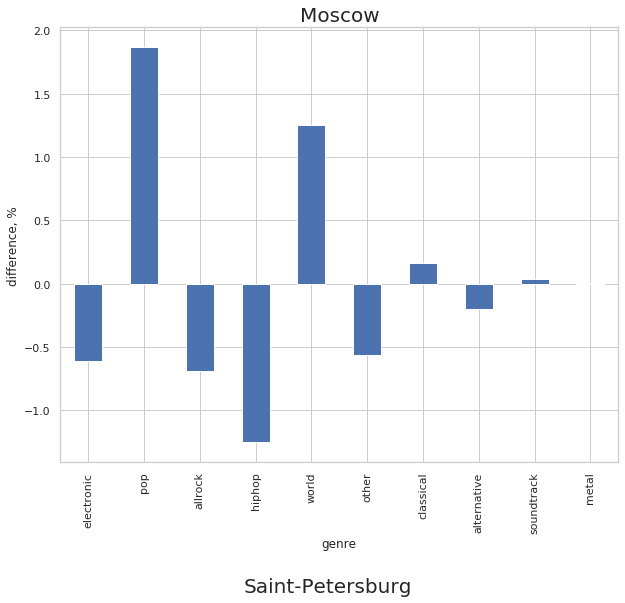

In [279]:
diff = norm_t10_mos*100-norm_t10_sp*100 #разность между долями жанров ежечасно
genre_difference = diff.mean(axis=1) # средняя разница между ежечасной разницой жанров
plt.figure(figsize=(10, 8))
sns.set(style='whitegrid')
genre_difference.plot(kind='bar').set_title('Moscow',  fontsize = 20)
plt.figtext(0.38, -0.1, "Saint-Petersburg",  fontsize = 20)
plt.ylabel("difference, %")

И снова максимальная разница в 2% говорит о том, что массовые предпочтения меломанов Москвы и Петербурга схожи.

Для для того чтобы окончательно удостовериться в этом, оценим насколько различны популярности поджанров в этих городах.

Text(0, 0.5, 'difference, %')

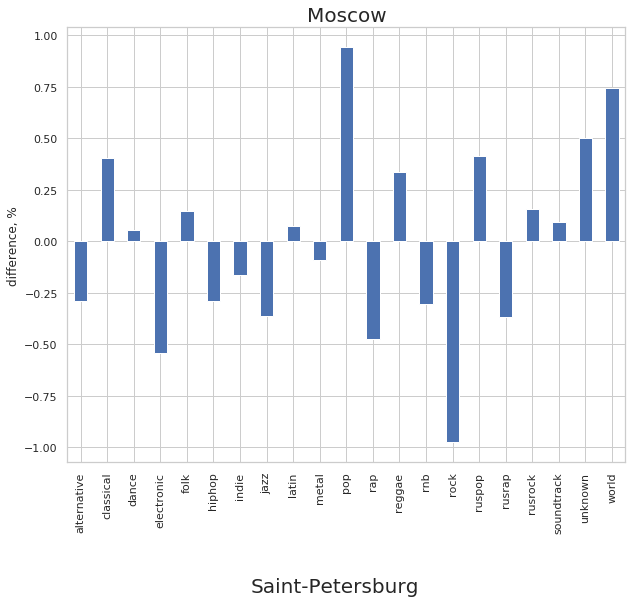

In [280]:
top_subgenres_m = list(df.query("city == 'Moscow'").subgenre.value_counts().head(20).index)
top_subgenres_sp = list(df.query("city == 'Saint-Petersburg'").subgenre.value_counts().head(20).index)
top_subgenres = top_subgenres_m + list(set(top_subgenres_sp).difference(set(top_subgenres_m)))
t_subgenre_mos = df.query(("city == 'Moscow' & subgenre in @top_subgenres"))
t_subgenre_sp = df.query(("city == 'Saint-Petersburg' & subgenre in @top_subgenres"))
m = t_subgenre_mos.subgenre.value_counts()/t_subgenre_mos.subgenre.value_counts().sum()
s = t_subgenre_sp.subgenre.value_counts()/t_subgenre_sp.subgenre.value_counts().sum()
plt.figure(figsize=(10, 8))
(m*100-s*100).plot(kind='bar').set_title('Moscow',  fontsize = 20)
plt.figtext(0.38, -0.1, "Saint-Petersburg",  fontsize = 20)
plt.ylabel("difference, %")

И разница менее 1% окончательно отвергает гипотезу.


In [281]:
# spb_genres = spb_general.groupby('genre').user_id.count().sort_values(ascending=False)# одной строкой: группировка таблицы spb_general по столбцу 'genre', 
# # подсчёт числа значений 'genre' в этой группировке методом count(), 
# # сортировка получившегося Series в порядке убывания и сохранение в spb_genres

Выведите на экран первые десять строк `spb_genres`:

In [282]:
# spb_genres.head(10) # просмотр первых 10 строк spb_genres

In [283]:
# diff = norm_t10_mos*100-norm_t10_sp*100
# genre_difference = diff.mean(axis=1)
# plt.figure(figsize=(10, 8))
# sns.set(style='whitegrid')
# genre_difference.plot(kind='bar').set_title('Moscow',  fontsize = 20)
# plt.figtext(0.38, -0.1, "Saint-Petersburg",  fontsize = 20)
# plt.ylabel("difference, %")

In [284]:
# top_subgenres_m = list(df.query("city == 'Moscow'").subgenre.value_counts().head(20).index)
# top_subgenres_sp = list(df.query("city == 'Saint-Petersburg'").subgenre.value_counts().head(20).index)
# top_subgenres = top_subgenres_m + list(set(top_subgenres_sp).difference(set(top_subgenres_m)))
# t_subgenre_mos = df.query(("city == 'Moscow' & subgenre in @top_subgenres"))
# t_subgenre_sp = df.query(("city == 'Saint-Petersburg' & subgenre in @top_subgenres"))
# m = t_subgenre_mos.subgenre.value_counts()/t_subgenre_mos.subgenre.value_counts().sum()
# s = t_subgenre_sp.subgenre.value_counts()/t_subgenre_sp.subgenre.value_counts().sum()
# plt.figure(figsize=(10, 8))
# sns.set(style='whitegrid')
# (m*100-s*100).plot(kind='bar').set_title('Moscow',  fontsize = 20)
# plt.figtext(0.38, -0.1, "Saint-Petersburg",  fontsize = 20)
# plt.ylabel("difference, %")

**Выводы**

Гипотеза о том, что проживание в Петербурге окультуривает или проживание в Москве развращает музыкальные предпочтения и все остальные утверждающие этнических предпочтениях в музыке отвергнуты по имеющимся данным.


## Итоги исследования

Проверены три гипотезы и установлено:

1. День недели по-разному влияет на активность пользователей в Москве и Петербурге. 

Первая гипотеза полностью подтвердилась.

2. Музыкальные предпочтения не сильно меняются в течение недели — будь то Москва или Петербург.

Таким образом, вторая гипотеза отвергнута.

3. Во вкусах пользователей Москвы и Петербурга больше общего чем различий. Вопреки ожиданиям, предпочтения жанров в Петербурге идентичны московские.

Третья гипотеза не подтвердилась. Если различия в предпочтениях и существуют, на основной массе пользователей они незаметны.
